In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os

# Function to load the UCI HAR dataset from local files
def load_har_data_local(data_path):
    # Load training data
    X_train = pd.read_csv(os.path.join(data_path, 'train/X_train.txt'), delim_whitespace=True, header=None)
    y_train = pd.read_csv(os.path.join(data_path, 'train/y_train.txt'), delim_whitespace=True, header=None)
    
    # Load test data
    X_test = pd.read_csv(os.path.join(data_path, 'test/X_test.txt'), delim_whitespace=True, header=None)
    y_test = pd.read_csv(os.path.join(data_path, 'test/y_test.txt'), delim_whitespace=True, header=None)
    
    # Convert labels to categorical (one-hot encoding)
    y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=6)  # Subtract 1 to make labels 0-5
    y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=6)
    
    return X_train, X_test, y_train, y_test

# Path to the local dataset folder
data_path = r"C:\Users\HP\UCI HAR Dataset\UCI HAR Dataset"

# Load the dataset
X_train, X_test, y_train, y_test = load_har_data_local(data_path)

# Reshape data for CNN-LSTM input (samples, timesteps, features)
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the CNN-LSTM model
def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # CNN Layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    
    # LSTM Layer
    model.add(LSTM(100, return_sequences=False))  # Set return_sequences=False for final LSTM layer
    model.add(Dropout(0.5))
    
    # Fully Connected Layer
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
input_shape = (X_train.shape[1], X_train.shape[2])  
num_classes = y_train.shape[1] 
model = create_cnn_lstm_model(input_shape, num_classes)

model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 559, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 279, 64)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 279, 64)           0         
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                        

In [2]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       496
           1       0.88      0.96      0.92       471
           2       0.97      0.83      0.89       420
           3       0.88      0.76      0.82       491
           4       0.84      0.89      0.86       532
           5       0.95      1.00      0.97       537

    accuracy                           0.90      2947
   macro avg       0.91      0.90      0.90      2947
weighted avg       0.91      0.90      0.90      2947

Confusion Matrix:
[[475  18   3   0   0   0]
 [ 10 453   8   0   0   0]
 [ 29  42 349   0   0   0]
 [  0   1   0 375  93  22]
 [  0   0   0  50 475   7]
 [  0   0   0   0   0 537]]


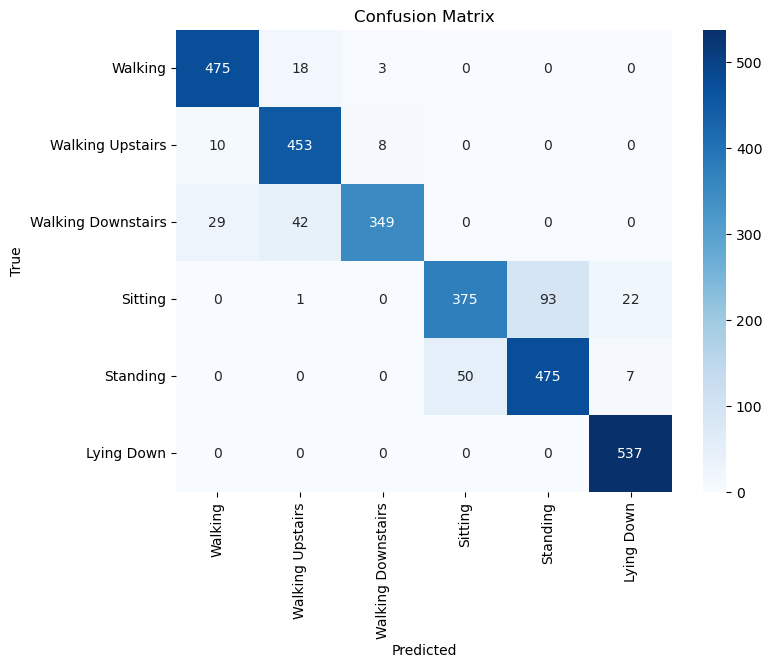

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Lying Down'],
            yticklabels=['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Lying Down'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

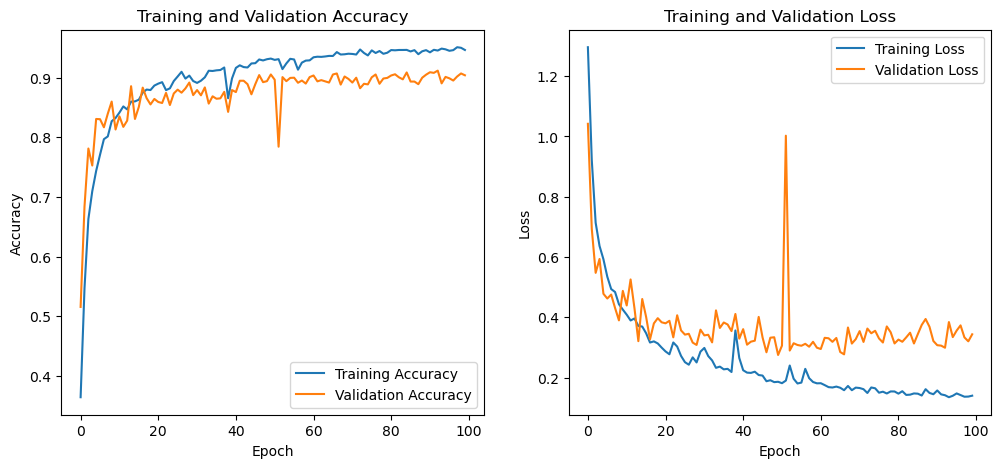

In [4]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

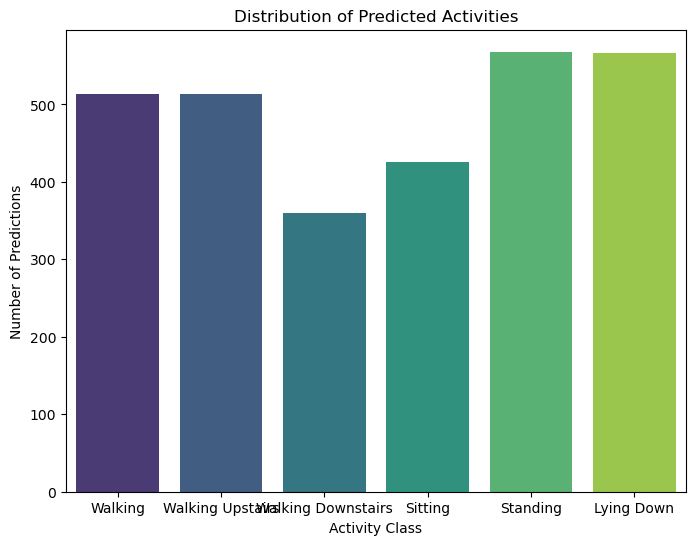

In [5]:
# Count the number of predictions for each class
prediction_counts = pd.Series(y_pred_classes).value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=prediction_counts.index, y=prediction_counts.values, palette='viridis')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], 
           labels=['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Lying Down'])
plt.xlabel('Activity Class')
plt.ylabel('Number of Predictions')
plt.title('Distribution of Predicted Activities')
plt.show()